<a href="https://colab.research.google.com/github/B10956048/113_Finance/blob/main/week11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from textblob import TextBlob

In [61]:
# 載入數據
news_data = pd.read_csv('/content/Combined_News_DJIA(train).csv')  # 替換成你的文件路徑
stock_data = pd.read_csv('/content/DJIA_table(train).csv')  # 替換成你的文件路徑

# 使用 pandas 自動推斷日期格式
news_data['Date'] = pd.to_datetime(news_data['Date'], format='mixed', dayfirst=True, errors='coerce')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='mixed', dayfirst=True, errors='coerce')

In [62]:
# 處理新聞數據
# Combine news headlines into a single text per day
news_data['Combined_Text'] = news_data.iloc[:, 2:27].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# Extract sentiment from news
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

news_data['Sentiment'] = news_data['Combined_Text'].apply(get_sentiment)
data = pd.merge(stock_data, news_data[['Date', 'Sentiment', 'Label']], on='Date')

In [63]:
data

,Date,Open,High,Low,Close,Volume,Adj Close,Sentiment,Label
0,2015-12-31,17590.66016,17590.66016,17421.16016,17425.02930,93690000,17425.02930,0.034860,0
1,2015-12-30,17711.93945,17714.13086,17588.86914,17603.86914,59760000,17603.86914,-0.010854,0
2,2015-12-29,17547.36914,17750.01953,17547.36914,17720.98047,69860000,17720.98047,0.101038,1
3,2015-12-28,17535.66016,17536.90039,17437.33984,17528.26953,59770000,17528.26953,-0.030512,0
4,2015-12-24,17593.25977,17606.33984,17543.94922,17552.16992,40350000,17552.16992,0.052091,0
...,...,...,...,...,...,...,...,...,...
1858,2008-08-14,11532.07031,11718.28027,11450.88965,11615.92969,159790000,11615.92969,0.040677,1
1859,2008-08-13,11632.80957,11633.78027,11453.33984,11532.95996,182550000,11532.95996,0.011398,0
1860,2008-08-12,11781.70020,11782.34961,11601.51953,11642.46973,173590000,11642.46973,-0.046530,0
1861,2008-08-11,11729.66992,11867.11035,11675.53027,11782.34961,183190000,11782.34961,0.121956,1


In [64]:
# Prepare features and labels
stock_features = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']]
sentiment_features = data[['Sentiment']]
labels = data['Label']

In [65]:
# Standardize numerical features
scaler = StandardScaler()
stock_features_scaled = scaler.fit_transform(stock_features)

In [66]:
# 數據分割
X_stock_train, X_stock_test, X_sentiment_train, X_sentiment_test, y_train, y_test = train_test_split(
    stock_features_scaled, sentiment_features, labels, test_size=0.2, random_state=42
)

In [67]:
# 構建股價子模型
stock_input = Input(shape=(X_stock_train.shape[1],), name='Stock_Input')
stock_dense = Dense(64, activation='relu')(stock_input)
stock_dropout = Dropout(0.3)(stock_dense)
stock_output = Dense(32, activation='relu')(stock_dropout)

In [68]:
# 構建情緒子模型
sentiment_input = Input(shape=(X_sentiment_train.shape[1],), name='Sentiment_Input')
sentiment_dense = Dense(32, activation='relu')(sentiment_input)
sentiment_output = Dense(16, activation='relu')(sentiment_dense)

In [69]:
# 晚期融合
combined = Concatenate()([stock_output, sentiment_output])
fusion_dense = Dense(64, activation='relu')(combined)
fusion_dropout = Dropout(0.3)(fusion_dense)
final_output = Dense(1, activation='sigmoid', name='Final_Output')(fusion_dropout)

In [70]:
# 構建最終模型
model = Model(inputs=[stock_input, sentiment_input], outputs=[final_output])
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [71]:
# 訓練模型
model.fit(
    [X_stock_train, X_sentiment_train],
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4988 - loss: 0.6980 - val_accuracy: 0.5369 - val_loss: 0.6905
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4843 - loss: 0.6965 - val_accuracy: 0.5570 - val_loss: 0.6894
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5079 - loss: 0.6939 - val_accuracy: 0.5503 - val_loss: 0.6884
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5279 - loss: 0.6942 - val_accuracy: 0.5738 - val_loss: 0.6896
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5087 - loss: 0.6910 - val_accuracy: 0.5503 - val_loss: 0.6896
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5300 - loss: 0.6932 - val_accuracy: 0.5570 - val_loss: 0.6895
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5353 - loss: 0.6913 - val_accuracy: 0.5503 - val_loss: 0.6882
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5174 - loss: 0.6905 - val_accuracy: 0.5638 - val_loss:

In [77]:
from re import X
# 評估模型
# print(X_stock_test)
# print(X_sentiment_test)
y_pred = (model.predict([X_stock_test, X_sentiment_test]) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.58


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


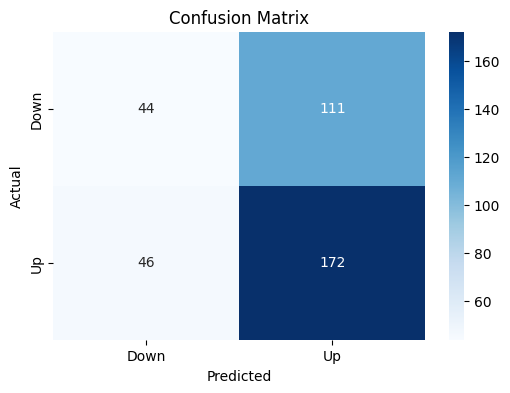

Classification Report:
              precision    recall  f1-score   support

        Down       0.49      0.28      0.36       155
          Up       0.61      0.79      0.69       218

    accuracy                           0.58       373
   macro avg       0.55      0.54      0.52       373
weighted avg       0.56      0.58      0.55       373



In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 生成混淆矩陣
y_pred = (model.predict([X_stock_test, X_sentiment_test]) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# 可視化混淆矩陣
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 輸出分類報告
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))
